# 导入依赖包

In [64]:
import pandas as pd
import csv
import numpy as np
from amp.utils import basic_model_serializer
import amp.data_utils.sequence as du_sequence
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

# 加载模型

In [65]:
bms = basic_model_serializer.BasicModelSerializer()
amp_classifier = bms.load_model('models/amp_classifier')
amp_classifier_model = amp_classifier()
mic_classifier = bms.load_model('models/mic_classifier/')
mic_classifier_model = mic_classifier() 

/geniusland/home/xiaoliwei/anaconda3/envs/new_fg_ds/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# 加载数据

In [66]:
from bio_utils import *

def get_peps(epoch):
    data_file = "/geniusland/home/xiaoliwei/C-VAE-GAN/samples/adv-train_16th_test/adv_{}.csv".format(epoch)
    data = pd.read_csv(data_file)
    
    return data

# 准备自己的数据
data = get_peps(7001)
list_peps = []
list_amp = []
list_mic = []
print(len(data))
for i in range(len(data)):
    pep = data.iloc[i]['sequences']
    pep_ = pep.rstrip('#')
    pep_ = pep_.rstrip('*')
    if pep_.find('#') == -1:
        list_peps.append(pep_)
        list_amp.append(data.iloc[i]['amp_label'])
        list_mic.append(data.iloc[i]['mic_label'])
    
seq_list = np.array(list_peps).squeeze().tolist()
pad_seq = du_sequence.pad(du_sequence.to_one_hot(seq_list))

2688


# 预测

In [67]:
pred_amp = amp_classifier_model.predict(pad_seq)
pred_mic = mic_classifier_model.predict(pad_seq)

84/84 [==============================] - 1s 11ms/step


In [68]:
# 测试属性
amp_label_predict = []
for amp in pred_amp:
    if amp > 0.5:
        amp_label_predict.append(1)
    else: amp_label_predict.append(0)

mic_label_predict = []
for mic in pred_mic:
    if mic > 0.5:
        mic_label_predict.append(1)
    else: mic_label_predict.append(0)

true_double = 0
true_amp_false_mic = 0
false_amp_true_mic = 0
false_double = 0
for i in range(0, len(list_amp)):
    if int(list_amp[i]) == amp_label_predict[i] and int(list_mic[i]) == mic_label_predict[i]:
        true_double = true_double + 1
    if int(list_amp[i]) == amp_label_predict[i] and int(list_mic[i]) != mic_label_predict[i]:
        true_amp_false_mic = true_amp_false_mic + 1
    if int(list_amp[i]) != amp_label_predict[i] and int(list_mic[i]) == mic_label_predict[i]:
        false_amp_true_mic = false_amp_true_mic + 1
    if int(list_amp[i]) != amp_label_predict[i] and int(list_mic[i]) != mic_label_predict[i]:
        false_double = false_double + 1

print(f"两个属性都对的序列数: {true_double}")
print(f"仅 amp 属性对的序列数: {true_amp_false_mic}")
print(f"仅 mic 属性对的序列数: {false_amp_true_mic}")
print(f"两个属性都不对的序列数: {false_double}")

两个属性都对的序列数: 1135
仅 amp 属性对的序列数: 642
仅 mic 属性对的序列数: 578
两个属性都不对的序列数: 333


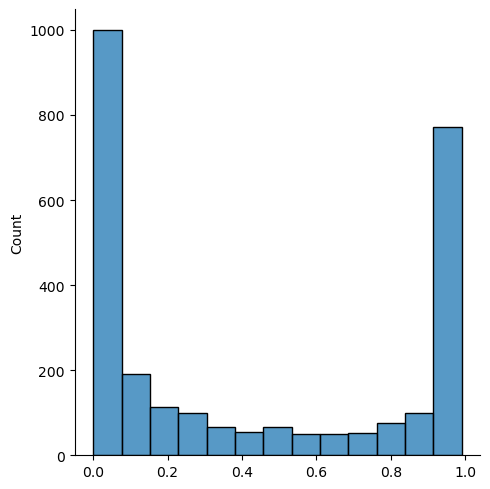

<Figure size 640x480 with 0 Axes>

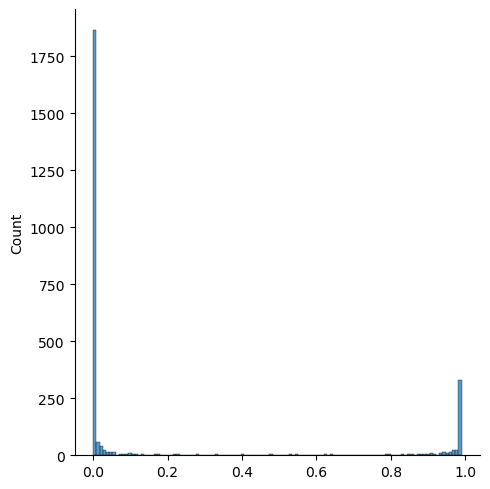

In [69]:
# 画图

import numpy as np
np.set_printoptions(suppress=True, threshold=np.inf)

static_amp = []
for amp in pred_amp:
    temp = amp * 100
    temp = int(temp)
    temp = temp / 100
    static_amp.append(temp)

static_mic = []
for mic in pred_mic:
    temp = mic * 100
    temp = int(temp)
    temp = temp / 100
    static_mic.append(temp)

import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(data = static_amp)
plt.figure()
sns.displot(data = static_mic)

In [70]:
from collections import Counter

list_95 = []
list_all = []
for i in range(0, 400):
    dict = {"sequence": get_peps(i)}
    data = pd.DataFrame(dict)
    # 准备自己的数据
    # data = pd.read_csv('/geniusland/home/xiaoliwei/seqgan_xlw/samples/basic/amp_test.csv')
    seq_list = np.array(data.sequence.tolist()).squeeze().tolist()
    pad_seq = du_sequence.pad(du_sequence.to_one_hot(seq_list))

    pred_amp = amp_classifier_model.predict(pad_seq)

    static_amp = []
    for amp in pred_amp:
        temp = amp * 100
        temp = int(temp)
        temp = temp // 5
        temp = temp * 5
        temp = temp / 100
        static_amp.append(temp)
    
    result = Counter(static_amp)

    list_95.append(result[0.95])
    list_all.append(len(static_amp))

x = list(range(0, 400))

plt.plot(x, list_95, 'b*--', label = "95%")
plt.plot(x, list_all, 'ro-', label = "num of seq")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/geniusland/home/xiaoliwei/C-VAE-GAN/samples/adv-train_15th_test/adv_0.csv'